In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#News Importation
true_news = pd.read_csv("/content/True.csv")
fake_news = pd.read_csv("/content/Fake.csv")
true_news.shape, fake_news.shape

((21417, 4), (23481, 4))

In [3]:
#First five rows
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
#First five rows
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
#Remove the subject and date column
true_news = true_news.drop(["subject","date","text"], axis =1)
fake_news = fake_news.drop(["subject","date", "text"], axis =1)

In [6]:
#Drop duplicate
true_news.drop_duplicates(inplace=True)
fake_news.drop_duplicates(inplace=True)
#Initiating a target variable 1 : true, 0: fake
true_news["target"] = 1
fake_news["target"] = 0
#Join the fake news and true news together
news = pd.concat([true_news, fake_news], ignore_index=True)
news = news.sample(frac=1, random_state=42).reset_index(drop=True)
news.head()

,title,target
0,TransCanada Officially Files $15 Billion Laws...,0
1,Trump accuses Mexico's Carlos Slim of trying t...,1
2,White House defends portrayal of 'armada' push...,1
3,"North Korea warns U.S. of 'greatest pain', rej...",1
4,ALMOST 100 YEARS LATER…Donald Trump Sounds A L...,0


<ipython-input-7-ee7a2ffadd25>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= news_counts.index, y= news_counts.values,palette="Blues_d")


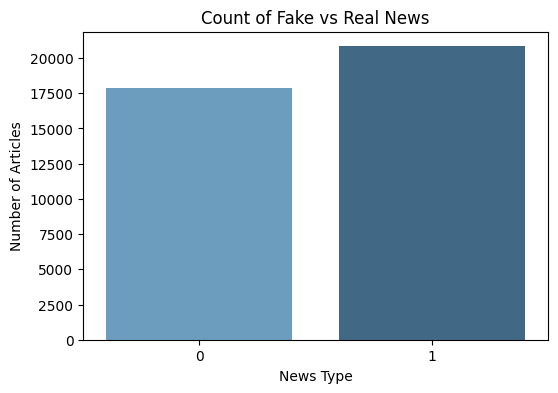

In [7]:
# Count fake and real news
news_counts = news["target"].value_counts()
# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x= news_counts.index, y= news_counts.values,palette="Blues_d")
plt.title("Count of Fake vs Real News")
plt.xlabel("News Type")
plt.ylabel("Number of Articles")
plt.show()

In [8]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(news)):
  review = re.sub('[^a-zA-Z]', ' ', news['title'][i])
  review = review.lower()
  review = review.split()

  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  review = ' '.join(review)
  corpus.append(review)

In [9]:
voc_size = 10000
onehot= [one_hot(words, voc_size)for words in corpus]

In [10]:
set_length = 100
embedded_docs = pad_sequences(onehot, padding = "pre", maxlen = set_length)
print(embedded_docs)

[[   0    0    0 ...  181 9962 8339]
 [   0    0    0 ... 1260  251 7889]
 [   0    0    0 ... 2215 6903 8386]
 ...
 [   0    0    0 ... 7433 1909 3143]
 [   0    0    0 ... 9232 5789 7385]
 [   0    0    0 ... 2898 1539 8511]]


In [11]:
# X and y variable
y = np.array(news["target"])
X = np.array(embedded_docs)
y.shape, X.shape

((38729,), (38729, 100))

In [12]:
# First split: train (70%) and temp (30% for val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Second split: validation (15%) and test (15%) from temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [13]:
from sklearn.utils import class_weight

In [14]:
# Compute class weights from y_train
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [46]:
vocab_size = 100000  # vocab size
embedding_dim = 100  # Embedding output size
maxlen = 100  # Sequence length
lstm = Sequential()
lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
lstm.add(LSTM(units=128, return_sequences=False))
lstm.add(Dense(1, activation='sigmoid'))
# Compile
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.build((None, maxlen))
lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,117,377 (38.59 MB)

 Trainable params: 10,117,377 (38.59 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
#Model fit
history = lstm.fit(X_train, y_train, epochs = 50, batch_size=64, class_weight=class_weights_dict,validation_data = (X_val, y_val))

Epoch 1/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8569 - loss: 0.3315 - val_accuracy: 0.9422 - val_loss: 0.1536
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9614 - loss: 0.1050 - val_accuracy: 0.9410 - val_loss: 0.1465
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9743 - loss: 0.0721 - val_accuracy: 0.9372 - val_loss: 0.1678
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9842 - loss: 0.0517 - val_accuracy: 0.9354 - val_loss: 0.1944
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9893 - loss: 0.0321 - val_accuracy: 0.9336 - val_loss: 0.2184
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9920 - loss: 0.0246 - val_accuracy: 0.9353 - val_loss: 0.2829
Epoch 7/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9934 - loss: 0.0188 - val_accuracy: 0.9332 - val_loss: 0.2962
Epoch 8/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9963 - loss: 0.0141 - val_

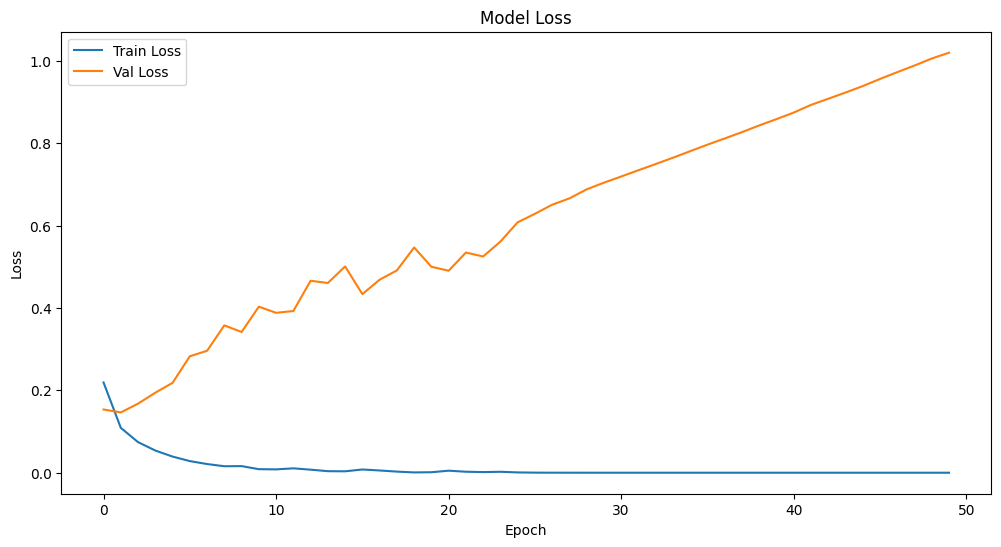

In [49]:
#Model training loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

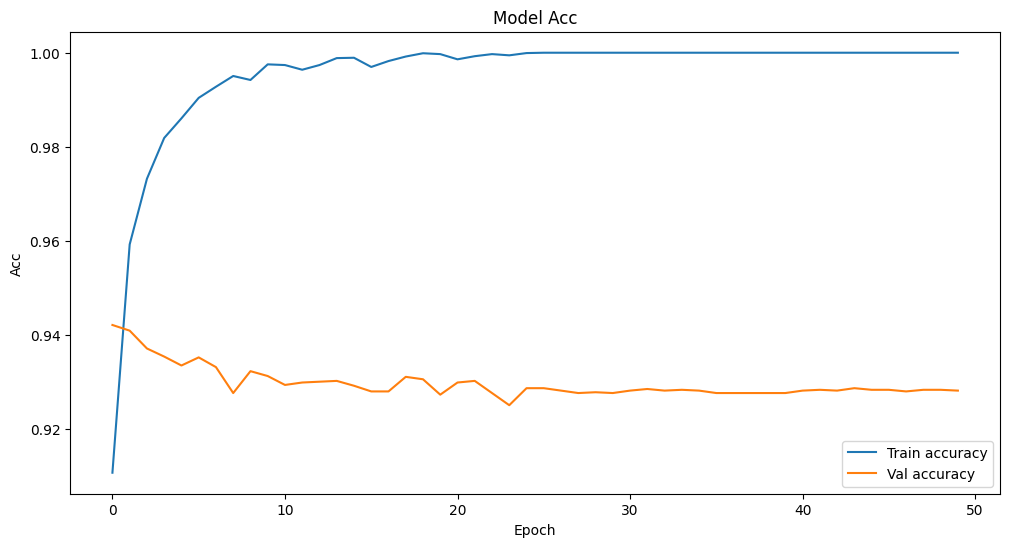

In [50]:
#Model training Accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.title('Model Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()

In [51]:
y_pred = lstm.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
acc_lstm = accuracy_score(y_test, y_pred)
print(f"LSTM model Accuracy: {acc_lstm * 100:.4f}%")

182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM model Accuracy: 92.6506%


In [52]:
print("LSTM model performance:\n", classification_report(y_test, y_pred))

LSTM model performance:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      2639
           1       0.93      0.94      0.93      3171

    accuracy                           0.93      5810
   macro avg       0.93      0.93      0.93      5810
weighted avg       0.93      0.93      0.93      5810



In [34]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm

In [23]:
# Train Test for BERT
train_texts, test_texts, train_labels, test_labels = train_test_split(
    news['title'].tolist(), news['target'].tolist(), test_size=0.2, random_state=42
)

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

In [31]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [30]:
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = NewsDataset(train_encodings, train_labels)
test_dataset = NewsDataset(test_encodings, test_labels)

In [32]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(5):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

Epoch 4: 100%|██████████| 1937/1937 [06:01<00:00,  5.36it/s, loss=0.000445]


In [42]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc_bert = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc_bert:.4f}")

Test Accuracy: 0.9782


In [43]:
print("BERT Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Fake News", "True News"]))

BERT Classification Report:
              precision    recall  f1-score   support

   Fake News       0.97      0.98      0.98      3578
   True News       0.98      0.98      0.98      4168

    accuracy                           0.98      7746
   macro avg       0.98      0.98      0.98      7746
weighted avg       0.98      0.98      0.98      7746



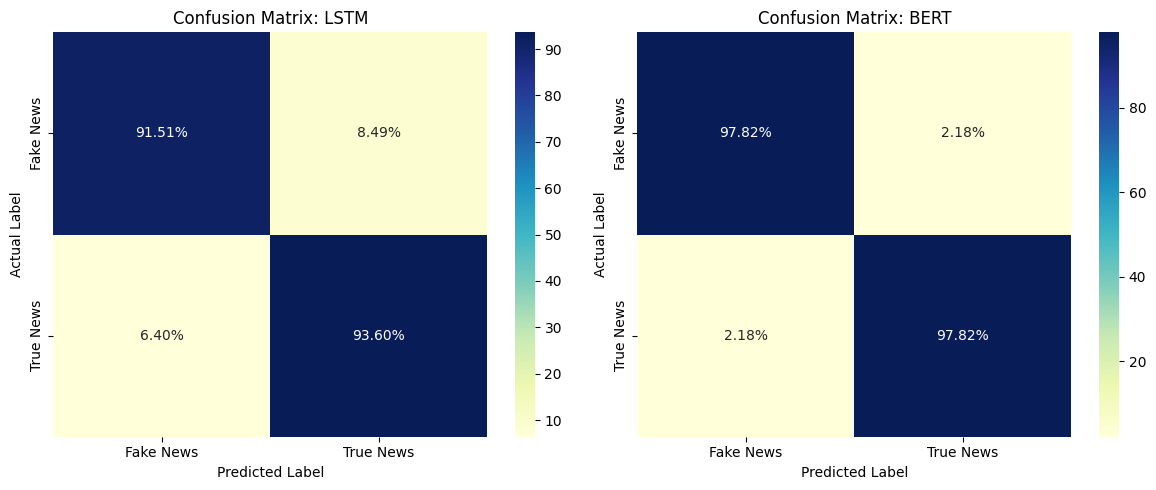

In [53]:
# Define class names
class_names = ["Fake News", "True News"]
# Compute confusion matrices
cm_lstm = confusion_matrix(y_test, y_pred)
cm_bert = confusion_matrix(all_labels, all_preds)
# Normalize to percentages
cm_lstm_percent = cm_lstm.astype('float') / cm_lstm.sum(axis=1)[:, np.newaxis] * 100
cm_bert_percent = cm_bert.astype('float') / cm_bert.sum(axis=1)[:, np.newaxis] * 100
# Format labels
labels_lstm = np.array([["{0:.2f}%".format(val) for val in row] for row in cm_lstm_percent])
labels_bert = np.array([["{0:.2f}%".format(val) for val in row] for row in cm_bert_percent])
# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# LSTM
sns.heatmap(cm_lstm_percent, annot=labels_lstm, fmt='', cmap="YlGnBu", cbar=True,
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title("Confusion Matrix: LSTM")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("Actual Label")
# BERT
sns.heatmap(cm_bert_percent, annot=labels_bert, fmt='', cmap="YlGnBu", cbar=True,
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title("Confusion Matrix: BERT")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("Actual Label")
plt.tight_layout()
plt.show()

<ipython-input-55-bdcb07e2f6ac>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df, x='Model', y='Accuracy', palette=['steelblue', 'seagreen'])


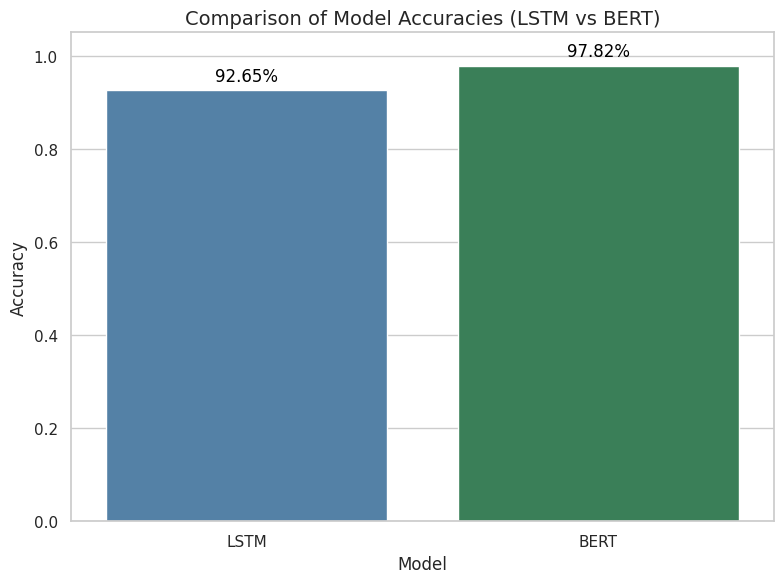

In [55]:
# Accuracy values
models = ['LSTM', 'BERT']
accuracies = [acc_lstm, acc_bert]
# Create a DataFrame for seaborn
df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies
})
# Set plot style
sns.set(style="whitegrid")
# Create the bar plot
plt.figure(figsize=(8, 6))
barplot = sns.barplot(data=df, x='Model', y='Accuracy', palette=['steelblue', 'seagreen'])

# Annotate each bar with the accuracy value
for index, row in df.iterrows():
    barplot.text(index, row.Accuracy + 0.02, f"{row.Accuracy:.2%}", color='black', ha="center", fontsize=12)
# Final plot formatting
plt.title('Comparison of Model Accuracies (LSTM vs BERT)', fontsize=14)
plt.ylim(0, 1.05)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.tight_layout()
plt.show()